# Import a required Library

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models

import pathlib
import os
from google.colab import drive
import zipfile

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import *
from tensorflow.keras.callbacks import ReduceLROnPlateau




# Connect a Googlr Drive with Collab

In [3]:

drive.mount('/content/drive')

Mounted at /content/drive


# Unzip The Dataset

In [4]:


zip_path = '/content/drive/MyDrive/Dataset/archive (2).zip'

extract_path = '/content/drive/MyDrive/Dataset'

if not os.path.exists(extract_path):
    os.makedirs(extract_path)

try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Zip file extracted to: {extract_path}")
except FileNotFoundError:
    print(f"Error: The file at {zip_path} was not found.")
except zipfile.BadZipFile:
    print("Error: The file is not a valid zip file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Zip file extracted to: /content/drive/MyDrive/Dataset


# **Path to dataset**

In [5]:

train_directory = '/content/drive/MyDrive/Dataset/casting_data/casting_data/train'
test_directory = '/content/drive/MyDrive/Dataset/casting_data/casting_data/test'

# Categories and No. of images

In [6]:
categories = os.listdir(train_directory)

nums = {}
for label in categories:
    label_path = os.path.join(train_directory, label)
    if os.path.isdir(label_path):
        nums[label] = len(os.listdir(label_path))

img_per_class = pd.DataFrame(list(nums.values()), index=nums.keys(), columns=["no. of images"])

print(img_per_class)

           no. of images
def_front           3758
ok_front            2875


# Data Preprocessing

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = image_dataset_from_directory(
    train_directory,
    image_size=(256, 256),
    batch_size=32,
    color_mode='rgb'
)

validation_generator = image_dataset_from_directory(
    test_directory,
    image_size=(256, 256),
    batch_size=32,
    color_mode='rgb'
)


Found 6633 files belonging to 2 classes.
Found 715 files belonging to 2 classes.


In [10]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

all_labels = []

for _, labels in train_generator:
    all_labels.extend(labels.numpy())
all_labels = np.array(all_labels)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)

class_weights = dict(zip(np.unique(all_labels), class_weights))

print("Class Weights:", class_weights)



Class Weights: {0: 0.8825172964342736, 1: 1.1535652173913042}


# Build the Model Using a CNN Architecture

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


In [ ]:
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

# Pre-Trained Model

In [11]:


img_height, img_width = 256, 256

base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation="relu")(x)
predictions = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Train the Model

In [12]:

lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                 patience=3,
                                 verbose=1,
                                 factor=0.5,
                                 min_lr=1e-6)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    class_weight=class_weights,
    callbacks=[lr_reduction]
)




Epoch 1/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 55s 197ms/step - accuracy: 0.8615 - loss: 0.3134 - val_accuracy: 0.9832 - val_loss: 0.0780 - learning_rate: 1.0000e-04
Epoch 2/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 66s 152ms/step - accuracy: 0.9846 - loss: 0.0627 - val_accuracy: 0.9930 - val_loss: 0.0415 - learning_rate: 1.0000e-04
Epoch 3/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 31s 150ms/step - accuracy: 0.9910 - loss: 0.0369 - val_accuracy: 0.9944 - val_loss: 0.0306 - learning_rate: 1.0000e-04
Epoch 4/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 41s 149ms/step - accuracy: 0.9928 - loss: 0.0270 - val_accuracy: 0.9958 - val_loss: 0.0230 - learning_rate: 1.0000e-04
Epoch 5/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 40s 146ms/step - accuracy: 0.9940 - loss: 0.0215 - val_accuracy: 0.9930 - val_loss: 0.0241 - learning_rate: 1.0000e-04
Epoch 6/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 39s 139ms/step - accuracy: 0.9932 - loss: 0.0198 - val_accuracy: 0.9930 - val_loss: 0.0216 - learning_rate: 1.0000e-04
Epoch 7/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 31s 14

#Evaluate the Model

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9982 - loss: 0.0053
Test Accuracy: 0.99


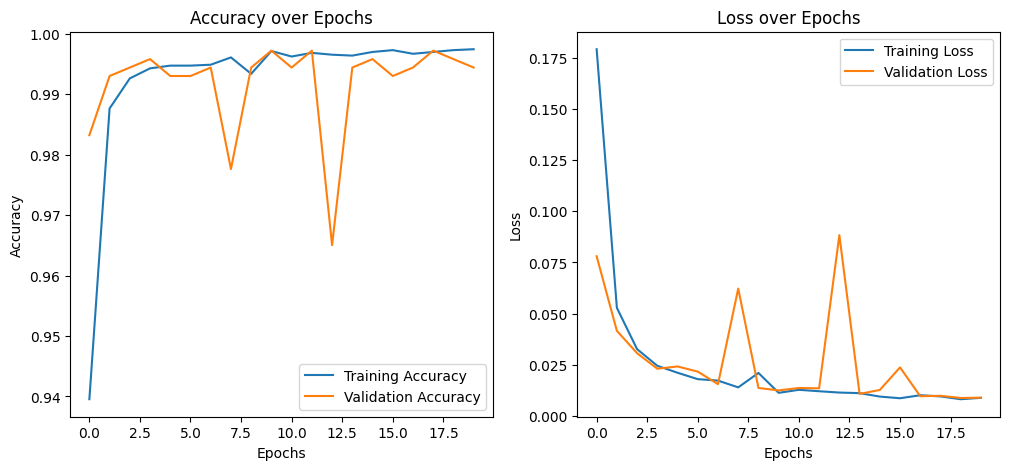

In [14]:
test_loss, test_acc = model.evaluate(validation_generator)
print(f"Test Accuracy: {test_acc:.2f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Save the Model

In [16]:
model.save('/content/drive/MyDrive/Dataset/industrial_equipment_classifier.h5')
print("Model saved successfully.")


Model saved successfully.


# Classification Report and Confusion Matrix

               precision    recall  f1-score   support

Non-Defective       1.00      1.00      1.00       453
    Defective       0.99      0.99      0.99       262

     accuracy                           0.99       715
    macro avg       0.99      0.99      0.99       715
 weighted avg       0.99      0.99      0.99       715



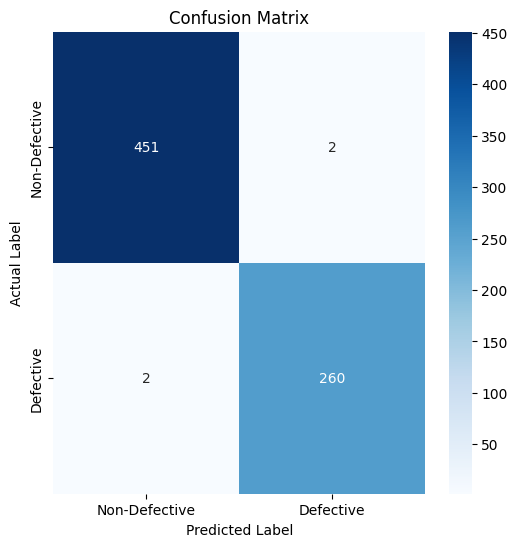

In [15]:


y_true = []
y_pred = []

for images, labels in validation_generator:
    y_true.extend(labels.numpy())
    preds = model.predict(images, verbose=0)
    y_pred.extend((preds > 0.5).astype("int32").flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(classification_report(y_true, y_pred, target_names=['Non-Defective', 'Defective']))

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Defective', 'Defective'],
            yticklabels=['Non-Defective', 'Defective'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()
